In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

!pip install findspark

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
#spark = SparkSession.builder.master("local[4]")  # this creates spark session to  run locally, the braket[] means number of cores 




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark ML basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
# importing required libraries
#!pip install OneHotEncoder

from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.streaming import StreamingContext
import pyspark.sql.types as tp
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer
#from pyspark.sql import Row

# define the schema
my_schema = tp.StructType([
  tp.StructField(name= 'id',          dataType= tp.IntegerType(),  nullable= True),
  tp.StructField(name= 'label',       dataType= tp.IntegerType(),  nullable= True),
  tp.StructField(name= 'tweet',       dataType= tp.StringType(),   nullable= True)
])


In [4]:
import pandas
import warnings
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = '10'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

# Give path of file
dataset_file = "/content/drive/MyDrive/big data/week 6/twitter_sentiments.csv"

# read the dataset  
dataset = spark.read.csv(dataset_file,inferSchema=True, header =True)

  

# view the data
dataset.show(5)

# print the schema of the file
dataset.printSchema()

+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
+---+-----+--------------------+
only showing top 5 rows

root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)



In [6]:
dataset.printSchema()


# remove null values
dataset.na.fill(0).show()


print(dataset.tail(5))

root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)

+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
|  6|    0|[2/2] huge fan fa...|
|  7|    0| @user camping to...|
|  8|    0|the next school y...|
|  9|    0|we won!!! love th...|
| 10|    0| @user @user welc...|
| 11|    0| â #ireland con...|
| 12|    0|we are so selfish...|
| 13|    0|i get to see my d...|
| 14|    1|@user #cnn calls ...|
| 15|    1|no comment!  in #...|
| 16|    0|ouch...junior is ...|
| 17|    0|i am thankful for...|
| 18|    1|retweet if you ag...|
| 19|    0|its #friday! ð...|
| 20|    0|as we all know, e...|
+---+-----+--------------------+
only showing top 20 rows

[Row(id=31958, label=0, tweet='ate @user isz that youuu?ð\x9f\x98\

In [14]:
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer

# define stage 1: tokenize the tweet text    
stage_1 = RegexTokenizer(inputCol= 'tweet' , outputCol= 'tokens', pattern= '\\W')
# define stage 2: remove the stop words
stage_2 = StopWordsRemover(inputCol= 'tokens', outputCol= 'filtered_words')

# define stage 3: create a word vector of the size 100
stage_3 = Word2Vec(inputCol= 'filtered_words', outputCol= 'vector', vectorSize= 100)


In [15]:
#Train, test split
train, test = dataset.randomSplit([0.8, 0.9], seed=12345)

In [16]:
print(train)
train.head(10)

DataFrame[id: int, label: int, tweet: string]


[Row(id=1, label=0, tweet=' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'),
 Row(id=2, label=0, tweet="@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"),
 Row(id=3, label=0, tweet='  bihday your majesty'),
 Row(id=4, label=0, tweet='#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  '),
 Row(id=8, label=0, tweet="the next school year is the year for exams.ð\x9f\x98¯ can't think about that ð\x9f\x98\xad #school #exams   #hate #imagine #actorslife #revolutionschool #girl"),
 Row(id=9, label=0, tweet='we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦ '),
 Row(id=11, label=0, tweet=' â\x86\x9d #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex'),
 Row(id=12, label=0, tweet

In [18]:
# Define MLP
from pyspark.ml.classification import MultilayerPerceptronClassifier

#layers = [100, 2]

layers = [100, 101, 100, 100, 100, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=10, 
                                         featuresCol= 'vector', 
                                         layers=layers, 
                                         labelCol= 'label',  
                                         stepSize = 0.01, 
                                         seed=1234)

In [21]:
from pyspark.ml import Pipeline
# setup the pipeline
pipeline = Pipeline(stages= [stage_1, stage_2, stage_3, trainer])

In [22]:
# Fit the pipeline to training documents.
mlp_model = pipeline.fit(train)
predictions_test = mlp_model.transform(test)
predictions_train = mlp_model.transform(train)


In [23]:
predictions_test.show()


+---+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|label|               tweet|              tokens|      filtered_words|              vector|       rawPrediction|         probability|prediction|
+---+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  5|    0| factsguide: soci...|[factsguide, soci...|[factsguide, soci...|[0.00623145544280...|[1.95376239150133...|[0.92550977227754...|       0.0|
|  6|    0|[2/2] huge fan fa...|[2, 2, huge, fan,...|[2, 2, huge, fan,...|[0.01033640914381...|[1.95320862056869...|[0.92541956557855...|       0.0|
|  7|    0| @user camping to...|[user, camping, t...|[user, camping, t...|[0.04970375024078...|[1.94781664672250...|[0.92447978635659...|       0.0|
| 10|    0| @user @user welc...|[user, user, welc...|[user, user, welc...|[0.02850510999560...|[1.94973636

In [24]:
#Get some sample predictions
predictions_test.select('tweet','label','prediction').show(20)

+--------------------+-----+----------+
|               tweet|label|prediction|
+--------------------+-----+----------+
| factsguide: soci...|    0|       0.0|
|[2/2] huge fan fa...|    0|       0.0|
| @user camping to...|    0|       0.0|
| @user @user welc...|    0|       0.0|
|i get to see my d...|    0|       0.0|
|@user #cnn calls ...|    1|       0.0|
|ouch...junior is ...|    0|       0.0|
|i am thankful for...|    0|       0.0|
|retweet if you ag...|    1|       0.0|
|its #friday! ð...|    0|       0.0|
|sad little dude.....|    0|       0.0|
| @user #tgif   #f...|    0|       0.0|
|beautiful sign by...|    0|       0.0|
|50 people went to...|    0|       0.0|
|it was a hard mon...|    0|       0.0|
|it's unbelievable...|    1|       0.0|
|morning~~ #travel...|    0|       0.0|
|i am thankful for...|    0|       0.0|
|when you finally ...|    0|       0.0|
|lovely echeveria ...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [25]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_test = evaluator.evaluate(predictions_test)
accuracy_train = evaluator.evaluate(predictions_train)

print("Test Error =  " , (1 - accuracy_test))
print("Test Accuracy = " , (accuracy_test))

print("Training Error =  " , (1 - accuracy_train))
print("Training Accuracy  = " , (accuracy_train))

predictions_test.printSchema()  
summary = predictions_test.summary
print(summary)


Test Error =   0.06975920679886682
Test Accuracy =  0.9302407932011332
Training Error =   0.07058196830470098
Training Accuracy  =  0.929418031695299
root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- vector: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

<bound method DataFrame.summary of DataFrame[id: int, label: int, tweet: string, tokens: array<string>, filtered_words: array<string>, vector: vector, rawPrediction: vector, probability: vector, prediction: double]>


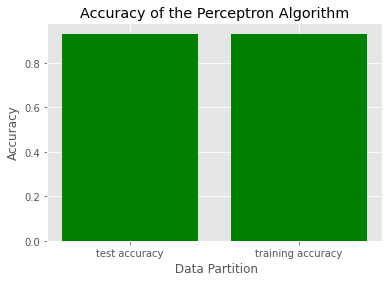

In [26]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = ['test accuracy', 'training accuracy']
accuracy = [accuracy_test, accuracy_train]

x_pos = [i for i, _ in enumerate(x)]  # you can replace _ with anynamne you want, 

plt.bar(x_pos, accuracy, color='green')
plt.xlabel(" Data Partition")
plt.ylabel("Accuracy")
plt.title("Accuracy of the Perceptron Algorithm")

plt.xticks(x_pos, x)

plt.show()